In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets.coco import CocoDetection
from torchvision import transforms
import os
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
data_dir = '/kaggle/input/dataset0613-cs331'
ann_file_train = os.path.join(data_dir, 'train/_annotations.coco.json')
ann_file_val = os.path.join(data_dir, 'valid/_annotations.coco.json')
ann_file_test = os.path.join(data_dir, 'test/_annotations.coco.json')

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_dataset = CocoDetection(root=os.path.join(data_dir, 'train'), annFile=ann_file_train, transform=F.to_tensor)
val_dataset = CocoDetection(root=os.path.join(data_dir, 'valid'), annFile=ann_file_val, transform=F.to_tensor)
test_dataset = CocoDetection(root=os.path.join(data_dir, 'test'), annFile=ann_file_test, transform=F.to_tensor)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [9]:
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 45.3MB/s]


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [12]:
writer = SummaryWriter()

In [13]:
num_epochs = 50
freeze_epochs = 5
classification_weight = 1.0
localization_weight = 1.0

for epoch in range(num_epochs):
    if epoch == freeze_epochs:
        for param in model.backbone.parameters():
            param.requires_grad = True

    running_classification_loss = 0.0
    running_localization_loss = 0.0

    model.train()
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)

        processed_targets = []
        for target_list in targets:
            boxes = []
            labels = []
            for obj in target_list:
                x_min, y_min, width, height = obj['bbox']
                if width > 0 and height > 0:
                    boxes.append([x_min, y_min, x_min + width, y_min + height])
                    labels.append(obj['category_id'])
            if len(boxes) > 0:
                processed_targets.append({
                    'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
                    'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                })

        if not processed_targets:
            continue

        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, processed_targets)
        classification_loss = loss_dict["classification"]
        localization_loss = loss_dict["bbox_regression"]

        # Tính tổng loss và backpropagation
        total_loss = (classification_weight * classification_loss +
                      localization_weight * localization_loss)

        total_loss.backward()
        optimizer.step()

        running_classification_loss += classification_loss.item()
        running_localization_loss += localization_loss.item()

    # Log loss vào TensorBoard
    writer.add_scalar('Loss/Classification', running_classification_loss / len(train_loader), epoch)
    writer.add_scalar('Loss/Localization', running_localization_loss / len(train_loader), epoch)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Classification Loss: {running_classification_loss / len(train_loader):.4f}, "
          f"Localization Loss: {running_localization_loss / len(train_loader):.4f}")

    # Scheduler step
    scheduler.step()

    # Đánh giá trên tập Validation
    model.eval()
    all_predictions = []

    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            image_id = targets[i][0]["image_id"] if isinstance(targets[i], list) else targets[i]["image_id"]

            for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
                all_predictions.append({
                    "image_id": int(image_id),
                    "category_id": int(label),
                    "bbox": [
                        float(box[0]),
                        float(box[1]),
                        float(box[2] - box[0]),
                        float(box[3] - box[1])
                    ],
                    "score": float(score)
                })

    # Lưu kết quả dự đoán và tính mAP
    predictions_file = "predictions.json"
    with open(predictions_file, "w") as f:
        json.dump(all_predictions, f)

    coco_gt = COCO(ann_file_val)
    coco_dt = coco_gt.loadRes(predictions_file)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    mAP = coco_eval.stats[0]
    print(f"Epoch {epoch + 1}/{num_epochs}, mAP: {mAP:.4f}")

# Đóng TensorBoard
writer.close()

Epoch 1/50, Classification Loss: 5.8072, Localization Loss: 0.9373
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.47s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.77s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.

In [14]:
torch.save(model, 'bestmodelv5x1_SSD320lite.pth')

In [24]:
print("Ground Truth Image IDs:", coco_gt.getImgIds())
print("Number of Predictions:", len(predictions))
print("Filtered Predictions:", len(filtered_predictions))

gt_image_ids = set(coco_gt.getImgIds())
pred_image_ids = set(p['image_id'] for p in predictions)
filtered_pred_image_ids = set(p['image_id'] for p in filtered_predictions)

print(f"GT Image IDs: {len(gt_image_ids)}")
print(f"Prediction Image IDs (Before Filter): {len(pred_image_ids)}")
print(f"Prediction Image IDs (After Filter): {len(filtered_pred_image_ids)}")
print(f"Common IDs (After Filter): {len(gt_image_ids & filtered_pred_image_ids)}")

invalid_boxes = [
    p for p in predictions
    if p['bbox'][2] <= 0 or p['bbox'][3] <= 0
]

print(f"Number of invalid boxes: {len(invalid_boxes)}")

coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.iouThrs = [0.5]  # Ngưỡng IoU = 0.5
coco_eval.evaluate()
coco_eval.accumulate()

tp = sum(coco_eval.eval['precision'] > 0)
print(f"True Positives: {tp}")


Ground Truth Image IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
Number of Predictions: 1565
Filtered Predictions: 168
GT Image IDs: 144
Prediction Image IDs (Before Filter): 144
Prediction Image IDs (After Filter): 143
Common IDs (After Filter): 143
Number of invalid boxes: 0
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.03s).
True Positives: [[[[0

In [25]:
from collections import Counter

pred_ids = [p['image_id'] for p in filtered_predictions]
duplicate_ids = [item for item, count in Counter(pred_ids).items() if count > 1]
print(f"Number of duplicate predictions: {len(duplicate_ids)}")


Number of duplicate predictions: 24


In [26]:
from collections import defaultdict

# Tạo dictionary lưu dự đoán duy nhất
unique_predictions = defaultdict(list)

for pred in filtered_predictions:
    key = (pred['image_id'], pred['category_id'])  # Sử dụng image_id và category_id để xác định đối tượng
    unique_predictions[key].append(pred)

# Giữ lại dự đoán có score cao nhất cho mỗi đối tượng
final_predictions = []
for key, preds in unique_predictions.items():
    preds.sort(key=lambda x: x['score'], reverse=True)  # Sắp xếp theo score giảm dần
    final_predictions.append(preds[0])  # Giữ lại dự đoán có score cao nhất

print(f"Number of predictions after removing duplicates: {len(final_predictions)}")


Number of predictions after removing duplicates: 167


In [27]:
# Lưu dự đoán đã loại bỏ trùng lặp
final_predictions_file = "final_predictions.json"
with open(final_predictions_file, "w") as f:
    json.dump(final_predictions, f)

# Tải lại COCO detections và đánh giá
coco_dt = coco_gt.loadRes(final_predictions_file)

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

In [28]:
for key, preds in unique_predictions.items():
    if len(preds) > 1:
        print(f"Image ID: {key[0]}, Category ID: {key[1]}, Scores: {[p['score'] for p in preds]}")


Image ID: 111, Category ID: 10, Scores: [0.8551713824272156, 0.7890524864196777]


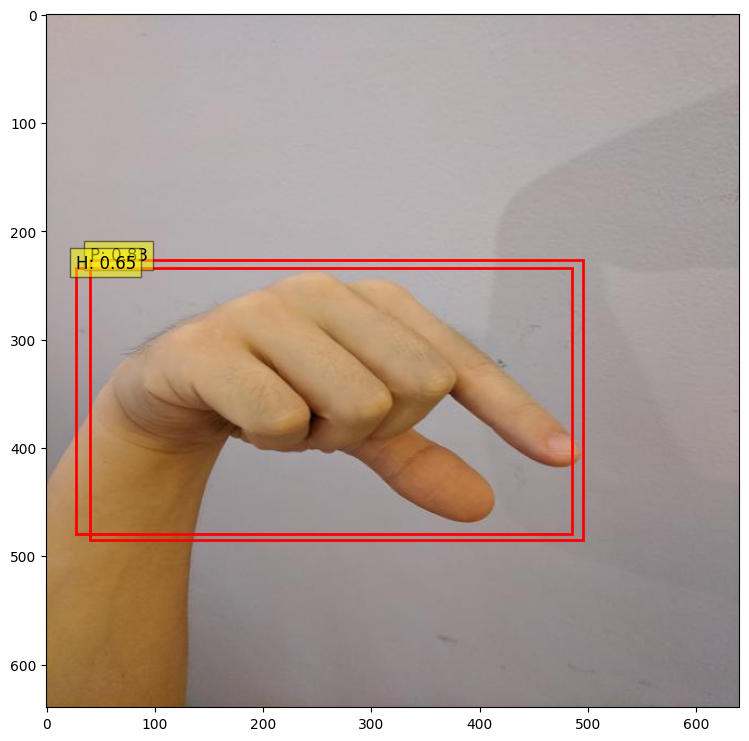

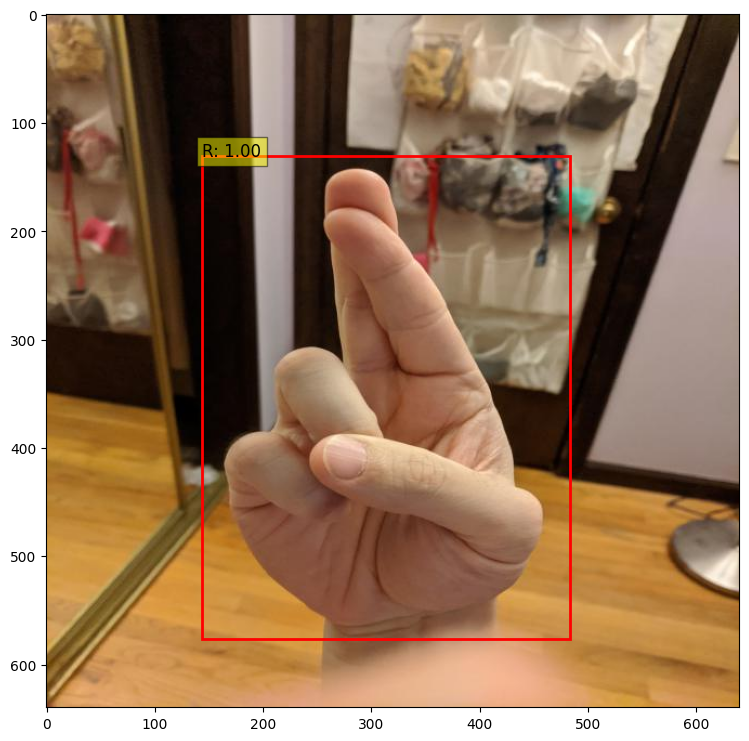

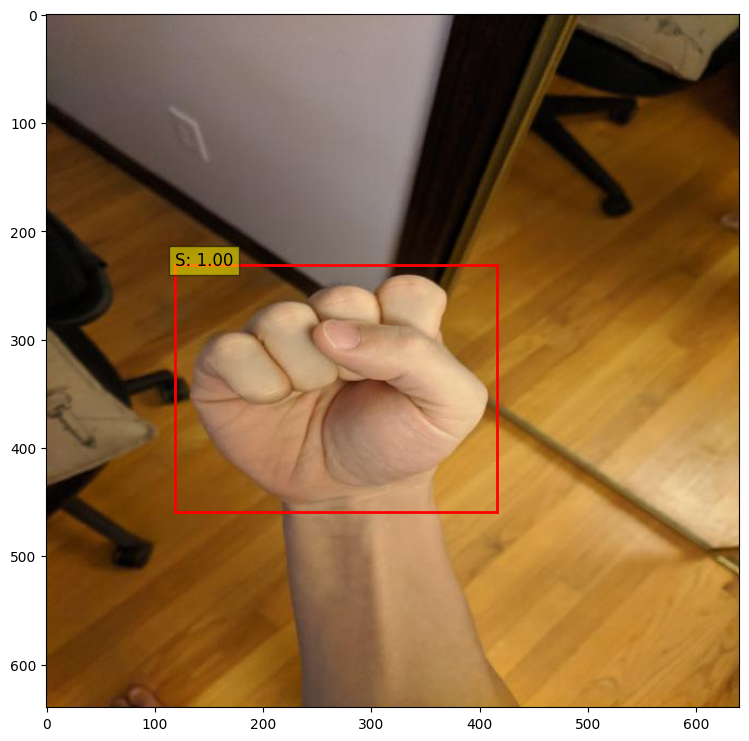

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from torchvision.transforms import functional as F
import random
from PIL import Image

# Hàm vẽ bounding boxes lên ảnh
def plot_image_with_boxes(image, boxes, labels, scores, category_names=None, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Vẽ các bounding boxes nếu score > threshold
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            # Kiểm tra label có trong phạm vi category_names không
            if label not in category_names:
                continue  # Bỏ qua nếu label không hợp lệ

            # Chuyển đổi từ [x_min, y_min, width, height] sang [x_min, y_min, x_max, y_max]
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # Thêm label và score vào ảnh
            label_text = category_names[label]
            ax.text(
                x_min, y_min, f'{label_text}: {score:.2f}',
                bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black'
            )

    plt.show()

# Lấy một số ảnh từ tập test và thực hiện dự đoán
model.eval()
num_samples = 3
category_names = {
    0: 'None',
    1: 'A',
    2: 'B',
    3: 'C',
    4: 'D',
    5: 'E',
    6: 'F',
    7: 'G',
    8: 'H',
    9: 'I',
    10: 'J',
    11: 'K',
    12: 'L',
    13: 'M',
    14: 'N',
    15: 'O',         
    16: 'P',          
    17: 'Q',         
    18: 'R',          
    19: 'S',         
    20: 'T',         
    21: 'U',        
    22: 'V',         
    23: 'W',     
    24: 'X',          
    25: 'Y',           
    26: 'Z',         
}

for i, (image, target) in enumerate(test_loader):
    if i >= num_samples:
        break
    image = image[0].to(device)  # Chọn 1 ảnh trong batch

    with torch.no_grad():
        prediction = model([image])

    # Chuyển đổi ảnh về dạng PIL để dễ vẽ
    image = F.to_pil_image(image.cpu())

    # Lấy các thông tin dự đoán: boxes, labels, scores
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Vẽ ảnh với các bounding box
    plot_image_with_boxes(image, boxes, labels, scores, category_names=category_names)



In [17]:
num_samples_in_train_set = len(train_loader.dataset)
print(f"Number of samples in train set: {num_samples_in_train_set}")

Number of samples in train set: 5040


In [18]:
num_samples_in_valid_set = len(val_loader.dataset)
print(f"Number of samples in valid set: {num_samples_in_valid_set}")

Number of samples in valid set: 144


In [19]:
num_samples_in_test_set = len(test_loader.dataset)
print(f"Number of samples in test set: {num_samples_in_test_set}")

Number of samples in test set: 72


/tmp/ipykernel_23/3686696266.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/bestmodelv5x1_SSD320lite.pth')


Label: 21, Class Name: u
Label: 22, Class Name: v
Label: 13, Class Name: m
Label: 11, Class Name: k
Label: 2, Class Name: b
Label: 14, Class Name: n
Label: 23, Class Name: w
Label: 18, Class Name: r
Label: 12, Class Name: l
Label: 26, Class Name: z


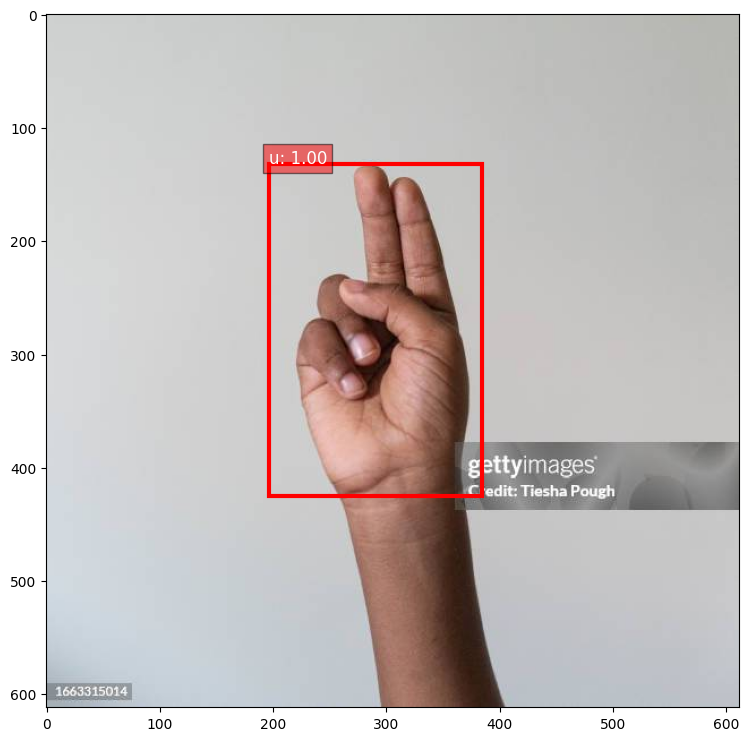

In [76]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load('/kaggle/working/bestmodelv5x1_SSD320lite.pth')
model = model.to(device)
model.eval()

category_names = ["none", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

image_path = '/kaggle/input/test001/gettyimages-1663315014-612x612.jpg'  # Thay thế với đường dẫn ảnh cục bộ của bạn
img = Image.open(image_path).convert("RGB")

img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(img_tensor)

boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

for label in labels:
    if label < len(category_names):
        print(f"Label: {label}, Class Name: {category_names[label]}")
    else:
        print(f"Label: {label}, Class Name: Unknown")

threshold = 0.6
filtered_boxes = boxes[scores > threshold]
filtered_labels = labels[scores > threshold]
filtered_scores = scores[scores > threshold]

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
    xmin, ymin, xmax, ymax = box
    if label < len(category_names):
        class_name = category_names[label]
    else:
        class_name = "Unknown"
    
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='red', linewidth=3))
    ax.text(xmin, ymin, f'{class_name}: {score:.2f}', 
            color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.show()
